딥러닝 파이토치 교과서 ch7. 5 p.393~417

### **7.5 LSTM**

- RNN의 기울기 소멸 문제 -> LSTM, GRU 으로 해결

7.5.1 LSTM 구조

▶ LSMT 순전파
- 망각 게이트, 입력 게이트, 출력게이트를 은닉층의 각 뉴런에 추가
- 망각 게이트: 과거 정보를 얼마나 기억할지 결정. 시그모이드의 출력이 0이면 과거 정보를 버리고(초기화) 1이면 보존(바로 직전의 정보를 메모리에 유지).
  - $f_t = σ(w_f[h_{t-1}, x_t])$
  - $c_t = f_t * c_{t-1}$

- 입력 게이트: 현재 정보를 기억할지 결정. 과거 정보와 현재 데이터를 입력받아 시그모이드/하이퍼볼릭 탄젠트 함수 기반 현재 정보 보존량을 결정. 계산값이 1이면 입력이 들어올 수 있도록 허용
  - $i_t = σ(w_i[h_{t-1}, x_t])$
  - $c_t̃ = tanh(w_c[h_{t-1}, x_t])$
  - $c = c_{t-1} + i_t * c_t̃$

- 셀: 각 단계에 대한 은닉 노드
  - 총합을 사용해 셀 값 반영, 기울기 소멸 문제 해결
  - 망각 게이트와 입력 게이트의 이전 셀 정보를 계산해 현제 단계의 셀 상태 (c_t)를 업데이트

- 출력 게이트: 과거 정보와 현재 데이터 사용해 뉴런의 출력을 결정. 이전 은닞 상태와 t번째 입력을 고려해 다음 은닉 상태 계산. LSTM에서 이 은닉 상태가 그 시점에서의 출력이 됨. 1이면 출력
  - $o_t = σ(w_o[h_{t-1}, x_t])$
  - $h_t = o_t * tanh(c_{t-1})$

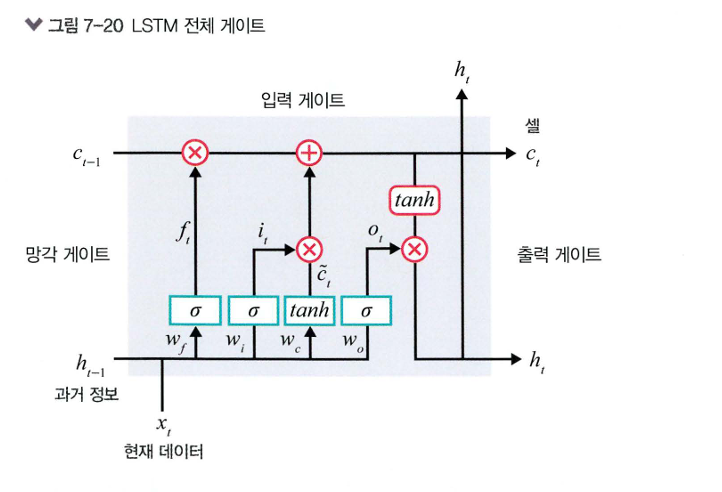

▶LSTM 역전파
- 셀을 통해 역전파 수행. 중단 없는 기울기
- 최종 오차는 모든 노드에 전파. 셀 내부적으로는 오차가 입력으로 전파됨
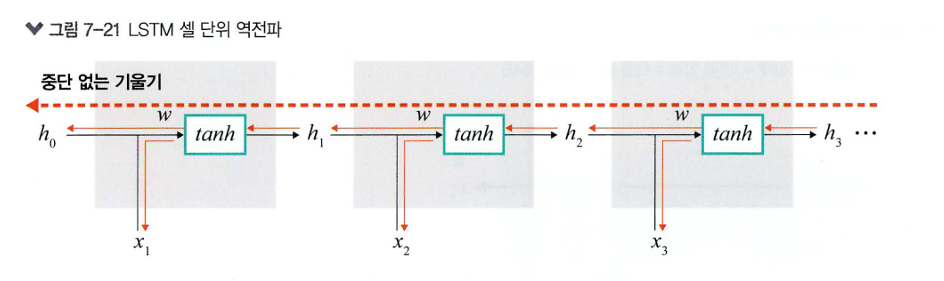

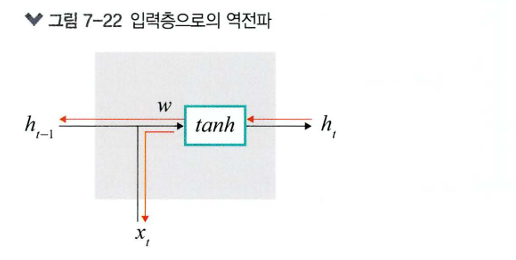

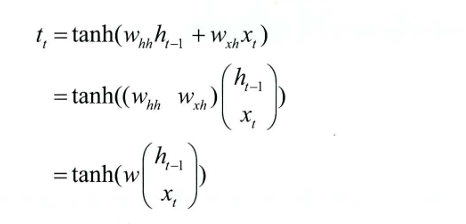



7.5.2 LSTM 셀 구현

- MNIST 데이터 이용해 실습. (손으로 쓴 숫자 이미지)
- 데이터 전처리: 데이터 정규화
- 데이터로더로 파일을 메모리에 불러옴.
- 배치 크기 및 에포크 등 변수 지정
- LSTM 셀 네트워크 구축
- 전반적 네트워크 구축
- 옵티마이저와 손실 함수 지정
- 모델 학습 및 검증 데이터셋으로 성능 확인
- 테스트 데이터겟으로 예측 성능 확인


In [2]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(125)

In [3]:
# 데이터 전처리
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
]) # 데이터 정규화(평균 0.5, 표준편차 1.0)

In [4]:
# 데이터셋 내려받기
from torchvision.datasets import MNIST

download_root = '../080289-main/chap07/MNIST_DATASET' # 데이터 받을 경로

train_dataset = MNIST(download_root, transform=mnist_transform,
                      train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform,
                     train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform,
                    train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.05MB/s]


In [5]:
# 데이터셋을 메모리로 가져오기
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [6]:
# 변수 값 지정
batch_size=100
n_iters=6000
num_epochs=n_iters/(len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

- 4 * hidden_size = 은닉층의 뉴런/유닛 * 4
  - 게이트가 망각/입력/셀/출력 네 개로 쪼개지기 때문에 4를 곱함. 일반적으로 바이어스도 4를 곱합(여기선 X)
- torch.chunk: 텐서 쪼갤때 사용
  - 텐서를 몇개로 쪼갤지, 어 차원을 기준으로 쪼갤지 결정
  - torxh.wqueeze(): 텐서 차원을 줄일 때 사용 -> (2,1)->(2,) 1차원 벡터로 변경
  - torch.mul(): 텐서에 곱셈

In [7]:
# LSTM 셀 네트워크 구축
class LSTMCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True) :
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std)

    def forward(self, x, hidden) :
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = F.sigmoid(ingate) # 입력 게이트에 시그모이드 적용
        forgetgate = F.sigmoid(forgetgate) # 망각 게이트에 시그모이드 적용
        cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 적용
        outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 적용

        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))

        return (hy, cy)

- LSTMCell(input_dim, hidden dim, layer_dim): 입력 특성, 은닉층 뉴런 개수, 은닉층 계층 개수

In [8]:
# LSTM 셀의 전반적 네트워크
class LSTMModel(nn.Module) :
   def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True) :
       super(LSTMModel, self).__init__()
       self.hidden_dim = hidden_dim

       self.layer_dim = layer_dim
       self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
       self.fc = nn.Linear(hidden_dim, output_dim)

   def forward(self, x) :
       if torch.cuda.is_available() :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

       if torch.cuda.is_available() :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
       else :
           c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

       outs = []
       cn =  c0[0,:,:]
       hn = h0[0,:,:]

       for seq in range(x.size(1)) : #LSTM 겔 계층 반복해 쌓음
           hn, cn = self.lstm(x[:, seq, :], (hn, cn))
           outs.append(hn)

       out = outs[-1].squeeze()
       out = self.fc(out)
       return out

In [10]:
# 옵티마이저와 손실 함수 지정
input_dim=28
hidden_dim=128
layer_dim=1
output_dim=18

model =  LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available() :
   model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate =0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# 모델 학습 및 성능 확인
seq_dim=28
loss_list = []
iter = 0
for epoch in range(num_epochs) :
   for i, (images ,labels) in enumerate(train_loader) :
       if torch.cuda.is_available() :
           images = Variable(images.view(-1, seq_dim, input_dim).cuda())
           labels = Variable(labels.cuda())

       else :
           images = Variable(images.view(-1, seq_dim, input_dim))
           labels = Variable(labels)

       optimizer.zero_grad()
       outputs = model(images)
       loss = criterion(outputs, labels)

       if torch.cuda.is_available() :
           loss.cuda()

       loss.backward()
       optimizer.step()
       loss_list.append(loss.item())
       iter += 1


       if iter % 500 == 0 :
           correct = 0
           total = 0

           for images, labels in valid_loader :

               if torch.cuda.is_available() :
                   images = Variable(images.view(-1, seq_dim, input_dim).cuda())
               else :
                   images = Variable(images.view(-1, seq_dim, input_dim))

               outputs = model(images)
               _, predicted = torch.max(outputs.data, 1)

               total += labels.size(0)
               if torch.cuda.is_available() :
                   correct += (predicted.cpu() == labels.cpu()).sum()

               else :
                   correct += (predicted == labels).sum()

           accuracy = 100 * correct / total
           print(f'Iteration : {iter} Loss : {loss.item()} Accuracy : {accuracy}')

Iteration : 500 Loss : 2.224165201187134 Accuracy : 14.75
Iteration : 1000 Loss : 0.7271389961242676 Accuracy : 70.30999755859375
Iteration : 1500 Loss : 0.36319851875305176 Accuracy : 89.30999755859375
Iteration : 2000 Loss : 0.1983393132686615 Accuracy : 92.94999694824219
Iteration : 2500 Loss : 0.12801074981689453 Accuracy : 94.86000061035156
Iteration : 3000 Loss : 0.16716021299362183 Accuracy : 94.98999786376953
Iteration : 3500 Loss : 0.12609314918518066 Accuracy : 96.66000366210938
Iteration : 4000 Loss : 0.09054200351238251 Accuracy : 96.22000122070312
Iteration : 4500 Loss : 0.06387943774461746 Accuracy : 97.4800033569336
Iteration : 5000 Loss : 0.21181179583072662 Accuracy : 97.48999786376953
Iteration : 5500 Loss : 0.022970670834183693 Accuracy : 97.77999877929688
Iteration : 6000 Loss : 0.13244086503982544 Accuracy : 97.80999755859375
Iteration : 6500 Loss : 0.12071669846773148 Accuracy : 97.94999694824219
Iteration : 7000 Loss : 0.0752805843949318 Accuracy : 97.97000122070

- 테스트 데이터셋으로도 성능 확인

In [12]:
# 테스트 데이터셋 이용 모델 예측 성능 확인
def evaluate(model, val_iter) :
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter :
        if torch.cuda.is_available() :
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else :
            images = Variable(images.view(-1, seq_dim, input_dim).to(device))

        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction='sum')
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [13]:
# 모델 예측 성능 확인
test_loss, test_acc = evaluate(model, test_loader)
print(f'Test Loss : {test_loss:5.2f} | Test Accuracy : {test_acc:5.2f}')

Test Loss :  0.07 | Test Accuracy :  0.98


MNIST는 사전 전처리된 데이터셋이므로 정확도가 높지만, 전처리되지 않은 데이터셋은 정확도 높이기 위해 하이퍼파라미터 수정 필요

7.5.3 LSTM 계층 구현

- 스타벅스 주가 데이터셋 사용

In [40]:
# 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [41]:
# 데이터셋 가져오기
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('/content/drive/MyDrive/ESAA/OB 과제/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


- 전처리
  - Date 갈럼을 인덱스로 사용. (날짜 칼럼은 임베딩 처리가 어려워 인덱스로 처리하면 편리함)
  - 정수 데이터를 실수로 변경 -> 텐서 변환 때 편리

In [42]:
# 날짜 칼럼을 인덱스로 사용
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [43]:
# 데이터 형식 변경
data['Volume'] = data['Volume'].astype(float)

- 데이터 셋 분리

In [44]:
# 훈련과 레이블 분리
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

- 분포를 고르게 맞추기 위해 스케일링 -> MinMaxScaler(), StandardScaler()로 분산 조정

In [45]:
# 데이터 분포 조정
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)


Training Shape : (200, 5) (200, 1)
Testing Shape : (53, 5) (53, 1)


- 네트워크에 정의된 형태 및 크기에 따라 데이터셋 크기 조정, 네트워크로 보냄
  - torch.reshape()

In [46]:
# 데이터셋의 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape :', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape : torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape : torch.Size([53, 1, 5]) torch.Size([53, 1])


In [47]:
# LSTM 네트워크
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [48]:
# 변수 값 설정
num_epochs = 1000
lr = 0.0001

input_size=5
hidden_size=2
num_layers=1

num_classes=1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

- 모델 학습

In [49]:
# 모델 학습
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.06217
Epoch : 100, loss : 0.01712
Epoch : 200, loss : 0.01553
Epoch : 300, loss : 0.01314
Epoch : 400, loss : 0.01135
Epoch : 500, loss : 0.01095
Epoch : 600, loss : 0.01208
Epoch : 700, loss : 0.01183
Epoch : 800, loss : 0.01172
Epoch : 900, loss : 0.01166


In [50]:
# 모델 예측 결과를 출력학 ㅣ위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

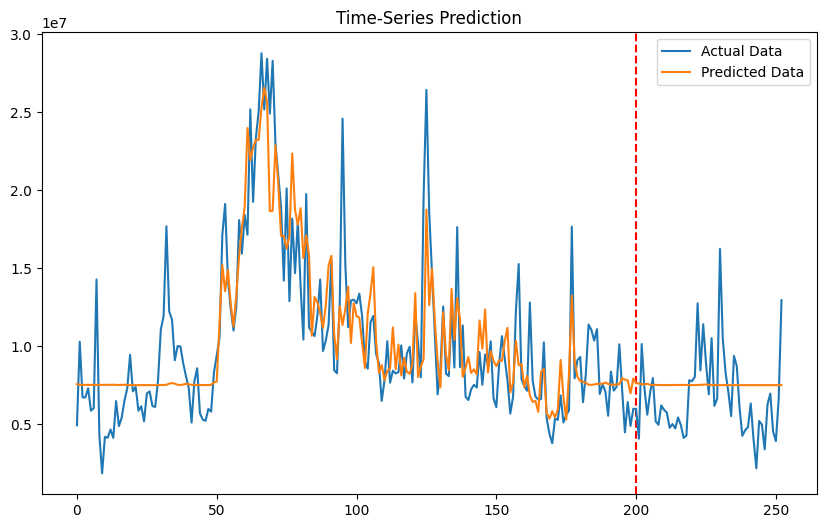

In [51]:
# 모델 예측 결과 출력
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()